In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


make sure to rename the columns by removing é


# Exploratory Data Analysis (EDA) for Packages and Receptacle Datasets

In [ ]:
# Load datasets
packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv',delimiter=';')
receptacle_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv',delimiter=';')

In [ ]:
# Rename for consistency
receptacle_df.rename(columns={
    'EVENT_TYPECD': 'EVENT_TYPE_CD',
    'nextetablissement_postal': 'next_etablissement_postal'
}, inplace=True)

In [ ]:
packages_df.shape, receptacle_df.shape

In [ ]:
#convert dates to dateTime for compatibility
packages_df['date'] = pd.to_datetime(packages_df['date'])
receptacle_df['date'] = pd.to_datetime(receptacle_df['date'])

In [ ]:
packages_df.info()


In [ ]:
receptacle_df.info()


In [ ]:
packages_df.head(n=5)

In [ ]:
receptacle_df.head(n=5)

 Initial Observations
- both datasets cover the period from 2023 to 2025
- we have no target variable in either dataset
- for packages dataset:
    - 6 features in total with 5 categorical and 1 numerical
    - MAILITM_FID is unique identifier for each package
    - RECPTCL_FID is foreign key linking to receptacle dataset
    - etablissement_postal and next_etablissement_postal have some null values
- for receptacle dataset:
    - 5 features in total with 4 categorical and 1 numerical
    - RECPTCL_FID is unique identifier for each receptacle
    - EVENT_TYPE_CD has some null values

In [ ]:
for column in packages_df.columns:
    print(f'{column} has {packages_df[column].nunique()} unique values.')
    print(f'{column} has {packages_df[column].isnull().sum()} null values.')
    print("\n")


In [ ]:
for column in receptacle_df.columns:
    print(f'{column} has {receptacle_df[column].nunique()} unique values.')
    print(f'{column} has {receptacle_df[column].isnull().sum()} null values.')
    print("\n")

we notice the following:<br>
- receptacle dataset has more unique values for RECPTCL_FID than packages dataset, indicating one-to-many relationship<br>
- MAILITM_FID is unique in packages dataset.<br>
- packages dataset have more unique date values than receptacle dataset.<br>
- both datasets have null values in etablissement_postal and next_etablissement_postal columns. This requires processing later on<br>
- packages dataset has more unique values in the next_etablissement_postal column compared to receptacle dataset but also more null values. **further investigation is needed to understand why**<br>


In [ ]:
packages_df.describe()

In [ ]:
receptacle_df.describe()

for EVENT_TYPE_CD we notice different range of values for packages and receptacle datasets indicating different types of events.<br>

#### Visualizations
for now we will visualize the distribution of EVENT_TYPE_CD in both datasets.<br>



In [ ]:
# Distribution of EVENT_TYPE_CD in packages dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=packages_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in packages dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Distribution of EVENT_TYPE_CD in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in Receptacle dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

for etablissement_postal and next_etablissement_postal I will start with visualizing the receptacle dataset since the packages dataset has a lot of unique values<br>

In [ ]:
# Distribution of etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='etablissement_postal')
plt.title('distribution of etablissement_postal in Receptacle dataset')
plt.xlabel('etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Distribution of next_etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='next_etablissement_postal')
plt.title('distribution of next_etablissement_postal in Receptacle dataset')
plt.xlabel('next_etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 1.  Top 10 locations to keep the map small
top_locs = receptacle_df['etablissement_postal'].value_counts().head(10).index
top_next = receptacle_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = receptacle_df[
    (receptacle_df['etablissement_postal'].isin(top_locs)) &
    (receptacle_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Receptacle Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

we notice that some etablissements have significantly higher traffic compared to others, indicating  major distribution centers.<br>

for etablissement_postal and next_etablissement_postal we will create a heatmap to visualize the flow between current location and next destination.<br>
Count of parcels moving from A to B to see the density of connections between them

In [ ]:
# 1.  Top 10 locations to keep the map small
top_locs = packages_df['etablissement_postal'].value_counts().head(10).index
top_next = packages_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = packages_df[
    (packages_df['etablissement_postal'].isin(top_locs)) &
    (packages_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Packages Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

In [ ]:
# Count packages per location
location_counts = packages_df['etablissement_postal'].value_counts().reset_index()
location_counts.columns = ['Location', 'Volume']

# keep only top 20 busiest centers
plt.figure(figsize=(12, 6))
sns.barplot(x='Volume', y='Location', data=location_counts.head(20), palette='viridis')
plt.title("Top 20 Busiest Postal Centers")
plt.xlabel("Number of Packages")
plt.ylabel("Center ID")
plt.show()

we notice the same pattern as before with some etablissements having significantly higher traffic compared to others.<br>

In [ ]:

# 1. Extract Time Features
packages_df['hour'] = packages_df['date'].dt.hour
packages_df['day_of_week'] = packages_df['date'].dt.day_name()

# 2. Create a Pivot Table (Cross-tabulation)
# Rows = Day, Cols = Hour, Values = Count of Scans
heatmap_data = pd.crosstab(
    packages_df['day_of_week'],
    packages_df['hour']
)

days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
heatmap_data = heatmap_data.reindex(days_order)

# 3. Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=.5, annot=False)
plt.title("Package Scan Activity by Day and Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Day of Week")
plt.show()

we notice that the busiest times for package scans are during weekdays, particularly from mid-morning to late afternoon.<br>

# Feature Extraction 

### stripe white spaces from IDs

- Load the data 
  - Choose between using the preprocessed or the raw with the null values

In [ ]:
#Use raw
# packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv',delimiter=';')
# receptacle_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv',delimiter=';')

#this is to use the preprocessed one
packages_df = pd.read_csv('../data/interim/chaotic_packages_df.csv',delimiter=',')
receptacle_df = pd.read_csv('../data/interim/chaotic_receptacles_df.csv',delimiter=',')

In [ ]:

packages_df['RECPTCL_FID'] = packages_df['RECPTCL_FID'].str.strip()
packages_df['MAILITM_FID'] = packages_df['MAILITM_FID'].str.strip()
receptacle_df['RECPTCL_FID'] = receptacle_df['RECPTCL_FID'].str.strip()

### Check RECPTCL_FID and MAILITM_FID having same length formats
if yes then we can split them into meaningfull parts

In [ ]:
same=1
print("\n=== RECPTCL_FID  ===")
print(f"testing if the lengths of RECPTCL_FID values are all the same:")
for val in packages_df['RECPTCL_FID'].values:
    if len(str(val)) != 29 :
        print(f"  {val} (length: {len(str(val))})")
        same=0
        break
if same==1:
    print('all same length' )

print("\n=== MAILITM_FID  ===")
print(f"testing if the lengths of MAILITM_FID values are all the same:")
for val in packages_df['MAILITM_FID'].values:
    if len(str(val)) != 13 :
        print(f"  {val} (length: {len(str(val))})")
        same=0
        break
if same==1:
    print ('all same length' )



### RECPTCL_FID Analysis
- **Format:** 29-character string (e.g., `USORDADZALGDAUN30050001900005`)
- **Data Quality:** No null values (1,000,000) | 215,867 unique values in receptacle dataset and 45306 unique values in packages dataset
- **Extractable Features:**
  - Origin Country (2 chars): US, FR, AE, etc.
  - Destination Country (2 chars): DZ, AI, AA, etc.

### MAILITM_FID Analysis
- **Format:** 13-character string according to the S10-12 patern (e.g., `CA000132868US`, `CA000340856PK`)
- **Data Quality:** No null values (1,000,000 packages)
- **Extractable Features:**
  - Service Indicator (2 chars): CA, etc.
  - Serial Number (8 chars): 00013286, 00034085, etc.
  - Check Digit (1 char): 8, 6, etc.
  - Country Code (3 chars, right-stripped): US, PK.


## Definition of the parser funtions
These functions are responsible for spliting the IDs into parts

In [ ]:
def parse_recptcl_fid(id_str):
    origin_country = id_str[0:2]
    destination_country = id_str[6:8]
    return origin_country, destination_country

def parse_mailitm_fid(id_str):
    service_indicator = id_str[0:2]
    serial_number = id_str[2:11]
    country_code = id_str[11:14].strip()
    return service_indicator, serial_number, country_code


### Apply parsing functions

In [ ]:
parsed_receptacle_df = receptacle_df.copy()
parsed_receptacle_df[['origin_country', 'destination_country']] = parsed_receptacle_df['RECPTCL_FID'].apply(lambda x: pd.Series(parse_recptcl_fid(x)))


In [ ]:
parsed_packages_df = packages_df.copy()
parsed_packages_df[['service_indicator', 'serial_number', 'country_code']] = parsed_packages_df['MAILITM_FID'].apply(lambda x: pd.Series(parse_mailitm_fid(x)))
parsed_packages_df[['origin_country','destination_country']] = parsed_packages_df['RECPTCL_FID'].apply(lambda x: pd.Series(parse_recptcl_fid(x)))

### show samples of new parsed data

In [ ]:

print("=== packages_df sample with new parsed columns ===")
parsed_packages_df.head()



In [ ]:
print("\n=== receptacle_df sample with new parsed columns ===")
parsed_receptacle_df.head()

# Analysis of the extrcted features


## 1. parsed_packages_df

In [ ]:

print("\n--- Unique Value Counts for parsed_packages_df ---")
print("\nFor receptacle FID parsing:")
print(f"Unique origin_country values: {parsed_packages_df['origin_country'].nunique()}")
print(f"Unique destination_country values: {parsed_packages_df['destination_country'].nunique()}")

print("="*50)
print("\nFor mail item FID parsing:")
print(f"Unique service_indicator values: {parsed_packages_df['service_indicator'].nunique()}")
print(f"Unique country_code values: {parsed_packages_df['country_code'].nunique()}")



## 2. parsed_receptacle_df 

In [ ]:
print("\n--- Unique Value Counts for parsed_receptacle_df ---")
print(f"Unique origin_country values: {parsed_receptacle_df['origin_country'].nunique()}")
print(f"Unique destination_country values: {parsed_receptacle_df['destination_country'].nunique()}")


## List values of the new columns obtained from receptacle FID parsing for both parsed dataframes

### 1. for parsed_packages_df

In [ ]:
#listing the values 
print("\n--- Values of origin_country ---")
print(parsed_packages_df['origin_country'].unique())

print("\n--- Values of destination_country ---")
print(parsed_packages_df['destination_country'].unique())


### 2. for parsed_receptacle_df

In [ ]:
#listing the values 
print("\n--- Values of origin_country ---")
print(parsed_receptacle_df['origin_country'].unique())

print("\n--- Values of destination_country ---")
print(parsed_receptacle_df['destination_country'].unique())


### Do the intersection of origin_country of both dataframes

In [ ]:
#do the intersection of origin_country values in both parsed datasets
packages_origin_countries = set(parsed_packages_df['origin_country'].unique())
receptacle_origin_countries = set(parsed_receptacle_df['origin_country'].unique())
common_origin_countries = packages_origin_countries.intersection(receptacle_origin_countries)
print("number of common origin_country values in both parsed datasets:", len(common_origin_countries))
print(f"\nCommon origin_country values in both paesed datasets: ")
print(common_origin_countries)
# remaining ones 
remaining_in_packages = packages_origin_countries - common_origin_countries
remaining_in_receptacle = receptacle_origin_countries - common_origin_countries
print(f"Remaining origin_country values only in parsed_packages_df:")
print(remaining_in_packages)
print(f"Remaining origin_country values only in parsed_receptacle_df:")
print(remaining_in_receptacle )

### list the values of both service indicators and country code

### 1. service indicators

In [ ]:
print("\n--- Values of service_indicator ---")
print(parsed_packages_df['service_indicator'].unique())



 we can see that there are values that don't follow the standards in the S10-12 format so we need to handle that correctly

In [ ]:
#transform country_code to uppercase for consistency
parsed_packages_df['service_indicator'] = parsed_packages_df['service_indicator'].str.upper()
print("values of service_indicator after transformation to uppercase:")
print(parsed_packages_df['service_indicator'].unique())
print("number of unique service indicators after transformation:", parsed_packages_df['service_indicator'].nunique())


### 2. country code

In [ ]:
print("\n--- Values of country codes ---")

print(parsed_packages_df['country_code'].unique())

we can see that many values for the country codes are numbers instead of ISO 3166-1 format these values should be replaced by the values of origin country gotten from the receptacle when doing the preprocessing

### replace them with the correct origin country code

In [ ]:
count = 0
for index, row in parsed_packages_df.iterrows():
    parsed_packages_df.at[index, 'country_code'] = row['country_code'].upper()
    if row['origin_country'] != row['country_code']:
        count += 1
print(f"Number of rows where origin_country does not match country_code: {count}")

### replace them

In [ ]:
for index, row in parsed_packages_df.iterrows():
    if row['origin_country'] != row['country_code']:
        parsed_packages_df.at[index, 'country_code'] = row['origin_country']

In [ ]:
#print the unique values again
print("\n--- Values of country codes after correction ---")
print(parsed_packages_df['country_code'].unique())
print("number of unique country codes after correction:", parsed_packages_df['country_code'].nunique())

## visualization of Origin Country distribution according to number of packages

### 1. for the parsed_packages_df

In [ ]:
origin_country_counts = parsed_packages_df['origin_country'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(origin_country_counts.index, origin_country_counts.values, color='steelblue')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Origin Country', fontsize=11)
plt.title('Top 20 Origin Countries by packages count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2. for the parsed_receptacle_df

In [ ]:
origin_country_counts = parsed_receptacle_df['origin_country'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(origin_country_counts.index, origin_country_counts.values, color='steelblue')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Origin Country', fontsize=11)
plt.title('Top 20 Origin Countries by receptacle count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Visualiation of the service indicator

In [ ]:
service_indicator_count = parsed_packages_df['service_indicator'].value_counts().head(20)
plt.figure(figsize=(12, 7))
plt.barh(service_indicator_count.index, service_indicator_count.values, color='mediumseagreen')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Service Indicator', fontsize=11)
plt.title('Top 20 Service Indicators by packages count', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Origin–Destination Flow Analysis

This section investigates the flow of receptacles and packages from origin countries to destination. We examine:
- packages count by origin country
- Top origin countries delivering to each destination
- Visual representation 

### 1. parsed_packages_df

In [ ]:
# packages count by origin country
origin_country_volume = parsed_packages_df['origin_country'].value_counts()
print("\n--- Packages count by Origin Country ---")
print(origin_country_volume.head(15))

# Create origin_country × destination matrix
flow_matrix = pd.crosstab(parsed_packages_df['origin_country'], 
                           parsed_packages_df['destination_country'])

# Keep only top 10 origin countries and top 10 destination countries for readability
top_origins = parsed_packages_df['origin_country'].value_counts().head(10).index
top_arrivals = parsed_packages_df['destination_country'].value_counts().head(10).index

flow_matrix_top = flow_matrix.loc[top_origins, top_arrivals]

print("\n--- Origin Country × destination Country (Top 10 × Top 10) ---")
print(flow_matrix_top)


In [ ]:
# Visualize origin × destination country flow
plt.figure(figsize=(14, 8))
sns.heatmap(flow_matrix_top, cmap='YlOrRd', annot=True, fmt='d', 
            cbar_kws={'label': 'packages Count'}, linewidths=0.5)
plt.title('packages Flow: Origin Country × destination country (Top 10 × Top 10)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Arrival Hub', fontsize=12)
plt.ylabel('Origin Country', fontsize=12)
plt.tight_layout()
plt.show()


### 2. parsed_receptacle_df

In [ ]:
# receptacle count by origin country
origin_country_receptacle_volume = parsed_receptacle_df['origin_country'].value_counts()
print("\n--- Receptacle count by Origin Country ---")
print(origin_country_receptacle_volume.head(15))

destination__receptacle_volume=parsed_receptacle_df['destination_country'].value_counts()
print("\n--- Receptacle count by destination ---")
print(destination__receptacle_volume.head(15))

# Create origin_country × destination matrix
receptacle_flow_matrix = pd.crosstab(parsed_receptacle_df['origin_country'], 
                           parsed_receptacle_df['destination_country'])

# Keep only top 10 origin countries and top 10 destination countries for readability
receptacle_top_origins = parsed_receptacle_df['origin_country'].value_counts().head(10).index
receptacle_top_arrivals = parsed_receptacle_df['destination_country'].value_counts().head(10).index

receptacle_flow_matrix_top = receptacle_flow_matrix.loc[receptacle_top_origins, receptacle_top_arrivals]

print("\n--- Origin Country × destination Country (Top 10 × Top 10) ---")
print(receptacle_flow_matrix_top)


In [ ]:
# Visualize origin × destination country flow
plt.figure(figsize=(14, 8))
sns.heatmap(receptacle_flow_matrix_top, cmap='YlOrRd', annot=True, fmt='d', 
            cbar_kws={'label': 'receptacles Count'}, linewidths=0.5)
plt.title('receptacles Flow: Origin Country × destination country (Top 10 × Top 10)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Arrival Country', fontsize=12)
plt.ylabel('Origin Country', fontsize=12)
plt.tight_layout()
plt.show()


### create pairs (origin, destination) for more detailed analysis

In [ ]:
parsed_packages_df['origin_destination'] = parsed_packages_df['origin_country'] + '_' + parsed_packages_df['destination_country']
parsed_receptacle_df['origin_destination'] = parsed_receptacle_df['origin_country'] + '_' + parsed_receptacle_df['destination_country']


listing the obtained values 

In [ ]:
print('(origin_destination) pairs obtained for ')
print("\nfor parsed_packages_df :")
print("\nNumber of unique values", parsed_packages_df['origin_destination'].nunique())
print("\nValues : ")
print(parsed_packages_df['origin_destination'].unique())
print("\nfor parsed_receptacles_df :")
print("\nNumber of unique values", parsed_receptacle_df['origin_destination'].nunique())
print("\nValues : ")
print(parsed_receptacle_df['origin_destination'].unique())


### visualization of obtained results 

### 1. parsed_packages_df

In [ ]:
origin_dest_counts = parsed_packages_df['origin_destination'].value_counts()
top_origin_dest_counts= origin_dest_counts.head(15)
plt.figure(figsize=(14, 7))
top_origin_dest_counts.plot(kind='bar')
plt.title('Histogram of (origin, destination) Pairs Based on Package Counts')
plt.xlabel('Origin_Destination')
plt.ylabel('Number of Packages')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



### 2. parsed_receptacle_df

In [ ]:
origin_dest_counts = parsed_receptacle_df['origin_destination'].value_counts()
top_origin_dest_counts = origin_dest_counts.head(15)

plt.figure(figsize=(14, 7))
top_origin_dest_counts.plot(kind='bar')
plt.title('Histogram of (origin, destination) Pairs Based on receptacle Counts')
plt.xlabel('Origin_Destination')
plt.ylabel('Number of receptacles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## origin_destination X etablissments analysis 

## 1. current etablissment 

### a. parsed_packages_df

In [ ]:
# For parsed_packages_df: visualize the histogram of counts by (origin_destination, etablissement_postal) pairs

# First, select top N most common (origin_destination, etablissement_postal) pairs for clarity
pair_counts_current = parsed_packages_df.groupby(['origin_destination', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_current = pair_counts_current.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_current,
    x='count',
    y=top_pairs_current.apply(lambda x: f"{x['origin_destination']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Current Etablissement) Pairs by Package Counts')
plt.xlabel('Number of Packages')
plt.ylabel('(Origin_Destination | Current Etablissement)')
plt.tight_layout()
plt.show()


### b. parsed_receptacle_df

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (origin_destination, etablissement_postal) pairs

# First, select top N most common (origin_destination, etablissement_postal) pairs for clarity
pair_counts_current_receptacle = parsed_receptacle_df.groupby(['origin_destination', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_current_receptacle = pair_counts_current_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_current_receptacle,
    x='count',
    y=top_pairs_current_receptacle.apply(lambda x: f"{x['origin_destination']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Destination | Current Etablissement)')
plt.tight_layout()
plt.show()


we can see that the ETAB0002 is dominating and we remark that when the destination is DZ
we'll try to confirm that by taking into consideration the destination only


In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (destination_country, etablissement_postal) pairs

# First, select top N most common (destination_country, etablissement_postal) pairs for clarity
pair_counts_dest_receptacle = parsed_receptacle_df.groupby(['destination_country', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_dest_receptacle = pair_counts_dest_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_dest_receptacle,
    x='count',
    y=top_pairs_dest_receptacle.apply(lambda x: f"{x['destination_country']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Destination Country, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Destination Country | Current Etablissement)')
plt.tight_layout()
plt.show()


### This is to test the origin 

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (origin_country, etablissement_postal) pairs

# First, select top N most common (origin_country, etablissement_postal) pairs for clarity
pair_counts_origin_receptacle = parsed_receptacle_df.groupby(['origin_country', 'etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_origin_receptacle = pair_counts_origin_receptacle.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_origin_receptacle,
    x='count',
    y=top_pairs_origin_receptacle.apply(lambda x: f"{x['origin_country']} | {x['etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin Country, Current Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin Country | Current Etablissement)')
plt.tight_layout()
plt.show()


most of the values with ETAB0002 values are european countries in addition to AE and China(CN)

## 2. Next etablissement

### a. parsed_packages_df

In [ ]:
# For parsed_packages_df: visualize the histogram of counts by (origin_destination, next_etablissement_postal)

# First, select top N most common (origin_destination, next_etablissement_postal) pairs for clarity
pair_counts = parsed_packages_df.groupby(['origin_destination', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs = pair_counts.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs,
    x='count',
    y=top_pairs.apply(lambda x: f"{x['origin_destination']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Next Etablissement) Pairs by Package Counts')
plt.xlabel('Number of Packages')
plt.ylabel('(Origin_Destination | Next Etablissement)')
plt.tight_layout()
plt.show()


### b. parsed_receptacle_df

In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by (origin_destination, next_etablissement_postal)

# First, select top N most common (origin_destination, next_etablissement_postal) pairs for clarity
pair_counts_recept = parsed_receptacle_df.groupby(['origin_destination', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_recept = pair_counts_recept.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_recept,
    x='count',
    y=top_pairs_recept.apply(lambda x: f"{x['origin_destination']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin-Destination, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Destination | Next Etablissement)')
plt.tight_layout()
plt.show()



Do for origin and for destination separately

In [ ]:

# For parsed_receptacle_df: visualize the histogram of counts by destination_country and next_etablissement_postal

# First, select top N most common (destination_country, next_etablissement_postal) pairs for clarity
pair_counts_dest = parsed_receptacle_df.groupby(['destination_country', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_dest = pair_counts_dest.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_dest,
    x='count',
    y=top_pairs_dest.apply(lambda x: f"{x['destination_country']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Destination Country, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Destination_Country | Next Etablissement)')
plt.tight_layout()
plt.show()


In [ ]:
# For parsed_receptacle_df: visualize the histogram of counts by origin_country and next_etablissement_postal

# First, select top N most common (origin_country, next_etablissement_postal) pairs for clarity
pair_counts_origin = parsed_receptacle_df.groupby(['origin_country', 'next_etablissement_postal']).size().reset_index(name='count')

# Sort and keep only top N pairs (by count)
top_n = 20
top_pairs_origin = pair_counts_origin.sort_values('count', ascending=False).head(top_n)

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_pairs_origin,
    x='count',
    y=top_pairs_origin.apply(lambda x: f"{x['origin_country']} | {x['next_etablissement_postal']}", axis=1),
    palette='viridis'
)
plt.title('Top (Origin Country, Next Etablissement) Pairs by Receptacle Counts')
plt.xlabel('Number of Receptacles')
plt.ylabel('(Origin_Country | Next Etablissement)')
plt.tight_layout()
plt.show()


from the analysis we can see that there are some etablissments that get congested (ETAB0030, ETAB0002, ETAB0006)

### Time analysis regarding origin

### 1. parsed_packages_df

In [ ]:
# Group the parsed_packages_df by date and origin_country to count packages per month per origin country
parsed_packages_df['date'] = pd.to_datetime(parsed_packages_df['date'])

# Group by origin_country and resample by month
ts_by_origin = parsed_packages_df.groupby(['origin_country', pd.Grouper(key='date', freq='ME')])['MAILITM_FID'].count().reset_index()

# Choose top 5 origin countries by total count for plotting
top_origin = parsed_packages_df['origin_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for origin in top_origin:
    ts = ts_by_origin[ts_by_origin['origin_country'] == origin]
    plt.plot(ts['date'], ts['MAILITM_FID'], marker='o', label=origin)

plt.title('Monthly Package count by Origin Country')
plt.xlabel('Date')
plt.ylabel('Number of Packages')
plt.legend(title='Origin Country')
plt.tight_layout()
plt.show()


### 2. parsed_receptacle_df

In [ ]:
# Group the parsed_receptacle_df by date and origin_country to count receptacles per month per origin country
parsed_receptacle_df['date'] = pd.to_datetime(parsed_receptacle_df['date'])

# Group by origin_country and resample by month
ts_by_origin_recept = parsed_receptacle_df.groupby(['origin_country', pd.Grouper(key='date', freq='ME')])['RECPTCL_FID'].count().reset_index()

# Choose top 5 origin countries by total count for plotting
top_origin_recept = parsed_receptacle_df['origin_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for origin in top_origin_recept:
    ts = ts_by_origin_recept[ts_by_origin_recept['origin_country'] == origin]
    plt.plot(ts['date'], ts['RECPTCL_FID'], marker='o', label=origin)

plt.title('Monthly Receptacle count by Origin Country')
plt.xlabel('Date')
plt.ylabel('Number of Receptacles')
plt.legend(title='Origin Country')
plt.tight_layout()
plt.show()


### Time analysis by destination

In [ ]:
# Group the parsed_packages_df by date and destination_country to count packages per month per destination country
parsed_packages_df['date'] = pd.to_datetime(parsed_packages_df['date'])

# Group by destination_country and resample by month
ts_by_dest = parsed_packages_df.groupby(['destination_country', pd.Grouper(key='date', freq='ME')])['MAILITM_FID'].count().reset_index()

# Choose top 5 destination countries by total count for plotting
top_dest = parsed_packages_df['destination_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for dest in top_dest:
    ts = ts_by_dest[ts_by_dest['destination_country'] == dest]
    plt.plot(ts['date'], ts['MAILITM_FID'], marker='o', label=dest)

plt.title('Monthly Package count by Destination Country')
plt.xlabel('Date')
plt.ylabel('Number of Packages')
plt.legend(title='Destination Country')
plt.tight_layout()
plt.show()


### 2. parsed_receptacle_df

In [ ]:
# Group the parsed_receptacle_df by date and destination_country to count receptacles per month per destination country
parsed_receptacle_df['date'] = pd.to_datetime(parsed_receptacle_df['date'])

# Group by destination_country and resample by month 
ts_by_dest_recept = parsed_receptacle_df.groupby(['destination_country', pd.Grouper(key='date', freq='ME')])['RECPTCL_FID'].count().reset_index()

# Choose top 5 destination countries by total count for plotting
top_dest_recept = parsed_receptacle_df['destination_country'].value_counts().head(5).index
plt.figure(figsize=(14, 7))

for dest in top_dest_recept:
    ts = ts_by_dest_recept[ts_by_dest_recept['destination_country'] == dest]
    plt.plot(ts['date'], ts['RECPTCL_FID'], marker='o', label=dest)

plt.title('Monthly Receptacle count by Destination Country')
plt.xlabel('Date')
plt.ylabel('Number of Receptacles')
plt.legend(title='Destination Country')
plt.tight_layout()
plt.show()


## Creating additional features 
 1. 'flow_type' column with values: 'inbound' (to DZ), 'outbound' (from DZ), 'local' (DZ to DZ), otherwise 'other'

In [ ]:
# Create a 'flow_type' column with values: 'inbound' (to DZ), 'outbound' (from DZ), 'local' (DZ to DZ), otherwise 'other'
def determine_flow_type(row):
    if row['destination_country'] == 'DZ' and row['origin_country'] == 'DZ':
        return 'local'
    elif row['destination_country'] == 'DZ':
        return 'inbound'
    elif row['origin_country'] == 'DZ':
        return 'outbound'
    else:
        return 'other'

parsed_packages_df['flow_type'] = parsed_packages_df.apply(determine_flow_type, axis=1)
parsed_receptacle_df['flow_type'] = parsed_receptacle_df.apply(determine_flow_type, axis=1)

# Print the number of each flow_type in parsed_packages_df
print("Flow type counts in parsed_packages_df:")
print(parsed_packages_df['flow_type'].value_counts())

# Print the number of each flow_type in parsed_receptacle_df
print("\nFlow type counts in parsed_receptacle_df:")
print(parsed_receptacle_df['flow_type'].value_counts())






we can see that there are some values of flow type with the type "other"

In [ ]:
# Display the first 10 rows of origin_country and destination_country for flow_type 'other' in parsed_receptacle_df
print(parsed_receptacle_df.loc[parsed_receptacle_df['flow_type'] == 'other', ['origin_country', 'destination_country']].head(10))



## Analysis of the relation between the flow_type and the event_type

## 1. parsed_packages_df

In [ ]:

# Analyse relation between flow_type and EVENT_TYPE_CD in parsed_packages_df

plt.figure(figsize=(14,7))
ax = sns.countplot(data=parsed_packages_df, x="EVENT_TYPE_CD", hue="flow_type", palette='Set2')
plt.title("Distribution of EVENT_TYPE_CD by flow_type in parsed_packages_df")
plt.xlabel("EVENT_TYPE_CD")
plt.ylabel("Count")
plt.legend(title="Flow Type")
plt.tight_layout()
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=8, padding=2)
plt.show()



## 2. parsed_receptacle_df

In [ ]:
# For each flow_type, list the unique EVENT_TYPE_CD values and the most frequent EVENT_TYPE_CD value
for flow in parsed_receptacle_df['flow_type'].unique():
    event_types = parsed_receptacle_df.loc[parsed_receptacle_df['flow_type'] == flow, 'EVENT_TYPE_CD'].unique()
    most_common_event_type = parsed_receptacle_df.loc[parsed_receptacle_df['flow_type'] == flow, 'EVENT_TYPE_CD'].mode()
    print(f"Flow type: {flow}")
    print(f"EVENT_TYPE_CD values: {sorted(event_types)}")
    if not most_common_event_type.empty:
        print(f"Most frequent EVENT_TYPE_CD: {most_common_event_type.iloc[0]}")
    else:
        print("No EVENT_TYPE_CD available")
    print()   


In [ ]:
plt.figure(figsize=(14,7))
ax = sns.countplot(data=parsed_receptacle_df, x="EVENT_TYPE_CD", hue="flow_type", palette='Set1')
plt.title("Distribution of EVENT_TYPE_CD by flow_type in parsed_receptacle_df")
plt.xlabel("EVENT_TYPE_CD")
plt.ylabel("Count")
plt.legend(title="Flow Type")
plt.tight_layout()

for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=8, padding=2)

plt.show()


we can see that there are major event types related to the inbound flow type( coming to DZ)

# Track multiple receptacles just to see the flow of events

In [ ]:
# Track multiple receptacles: visualize all events for 5 different RECPTCL_FID in parsed_receptacle_df
# Pick 5 unique RECPTCL_FID values to demonstrate
num_examples = 5
example_receptacle_ids = parsed_receptacle_df['RECPTCL_FID'].drop_duplicates().iloc[:num_examples]
for rid in example_receptacle_ids:
    print("\n--- Events for RECPTCL_FID:", rid, "---")
    display(parsed_receptacle_df[parsed_receptacle_df['RECPTCL_FID'] == rid][['RECPTCL_FID', 'date', 'EVENT_TYPE_CD', 'etablissement_postal', 'next_etablissement_postal']].sort_values('date').reset_index(drop=True))


plt.figure(figsize=(14, 5))

for i, receptacle_id in enumerate(example_receptacle_ids):
    ex_df = parsed_receptacle_df[parsed_receptacle_df['RECPTCL_FID'] == receptacle_id].sort_values('date')
    plt.plot(
        ex_df['date'],
        ex_df['EVENT_TYPE_CD'],
        marker='o',
        label=f"RECPTCL_FID: {receptacle_id}"
    )

plt.xticks(rotation=45)
plt.title(f"Event Timeline (EVENT_TYPE_CD) for {num_examples} Receptacles")
plt.xlabel("Date")
plt.ylabel("EVENT_TYPE_CD")
plt.tight_layout()
plt.legend()
plt.show()


# calculating the time of existence for each receptacle/ package 
   ## processing_duration 
   Note : this duration is calculated between min and max date and doesn't give the exact duration when min=max

### 1. parsed_packages_df

In [ ]:
# Calculate processing_duration (time from first to last event per MAILITM_FID)
# For each mail item, sort events by date, get min and max date per mail item
pkg_duration_df = (
    parsed_packages_df
    .sort_values(['MAILITM_FID', 'date'])
    .groupby('MAILITM_FID')['date']
    .agg(['min', 'max'])
    .reset_index()
)
pkg_duration_df.columns = ['MAILITM_FID', 'min_date', 'max_date']
pkg_duration_df['processing_duration'] = pkg_duration_df['max_date'] - pkg_duration_df['min_date']

# Merge 'processing_duration' back to parsed_packages_df
parsed_packages_df = parsed_packages_df.merge(
    pkg_duration_df[['MAILITM_FID', 'processing_duration']],
    on='MAILITM_FID',
    how='left'
)


display results

In [ ]:

# Display processing_duration statistics
print(parsed_packages_df[['MAILITM_FID', 'date', 'processing_duration']].drop_duplicates(subset=['processing_duration']).head(10))
#print the max value of processing_duration
max_duration = parsed_packages_df['processing_duration'].max()
#print the mail item(s) with the max processing_duration
max_duration_items = parsed_packages_df[parsed_packages_df['processing_duration'] == max_duration]['MAILITM_FID'].unique()
print(f"\nMaximum processing duration: {max_duration}")
print(f"Mail item(s) with maximum processing duration: {max_duration_items}")

#print the min value of processing_duration
min_duration = parsed_packages_df['processing_duration'].min()
#print the mail item(s) with the min processing_duration
min_duration_items = parsed_packages_df[parsed_packages_df['processing_duration'] == min_duration]['MAILITM_FID'].unique()
print(f"\nMinimum processing duration: {min_duration}")
print(f"Mail item(s) with minimum processing duration: {min_duration_items}")

visualization of the distribution of the packages according to the processing duration 

In [ ]:
# Visualize the distribution of packages by processing_duration
plt.figure(figsize=(14, 7))

# Convert processing_duration to total days for better visualization
parsed_packages_df['processing_duration_days'] = parsed_packages_df['processing_duration'].dt.total_seconds() / (24 * 3600)

# Create histogram
plt.hist(parsed_packages_df['processing_duration_days'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Processing Duration (days)', fontsize=11)
plt.ylabel('Number of Packages', fontsize=11)
plt.title('Distribution of Packages by Processing Duration', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Processing Duration Statistics:")
print(f"Mean: {parsed_packages_df['processing_duration_days'].mean():.2f} days")
print(f"Median: {parsed_packages_df['processing_duration_days'].median():.2f} days")
print(f"Std Dev: {parsed_packages_df['processing_duration_days'].std():.2f} days")
print(f"Min: {parsed_packages_df['processing_duration_days'].min():.2f} days")
print(f"Max: {parsed_packages_df['processing_duration_days'].max():.2f} days")

- This doesn't give a lot of insights, we try to analyse the event type and the duration 

In [ ]:
# Summary statistics for processing_duration by EVENT_TYPE_CD
duration_by_event = (
    parsed_packages_df
    .groupby("EVENT_TYPE_CD")['processing_duration_days']
    .describe()
)
print("Processing Duration Statistics by EVENT_TYPE_CD:")
print(duration_by_event)
print("\n")

# Visualize boxplot of processing_duration by EVENT_TYPE_CD
plt.figure(figsize=(14, 7))
sns.boxplot(x='EVENT_TYPE_CD', y='processing_duration_days', data=parsed_packages_df, showfliers=False)
plt.title('Processing Duration by EVENT_TYPE_CD', fontsize=14, fontweight='bold')
plt.xlabel('EVENT_TYPE_CD', fontsize=12)
plt.ylabel('Processing Duration (days)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Bar chart showing mean processing_duration by EVENT_TYPE_CD

In [ ]:
mean_duration_by_event = parsed_packages_df.groupby('EVENT_TYPE_CD')['processing_duration_days'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
mean_duration_by_event.plot(kind='barh', color='steelblue')
plt.xlabel('Mean Processing Duration (days)', fontsize=11)
plt.ylabel('EVENT_TYPE_CD', fontsize=11)
plt.title('Mean Processing Duration by EVENT_TYPE_CD', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


now we can see that some events type is a kind of groups of similar event types that have approximatly the same average number of processing duration 

## 2. parsed_receptacle_df

In [ ]:
# Calculate processing_duration (time from first to last event per RECPTCL_FID)
# For each receptacle, sort events by date, get min and max date per receptacle
rec_duration_df = (
    parsed_receptacle_df
    .sort_values(['RECPTCL_FID', 'date'])
    .groupby('RECPTCL_FID')['date']
    .agg(['min', 'max'])
    .reset_index()
)
rec_duration_df['processing_duration'] = rec_duration_df['max'] - rec_duration_df['min']

# Merge 'processing_duration' back to parsed_receptacle_df
parsed_receptacle_df = parsed_receptacle_df.merge(
    rec_duration_df[['RECPTCL_FID', 'processing_duration']],
    on='RECPTCL_FID',
    how='left'
)
# Display the first few rows to show the obtained processing_duration values
print(parsed_receptacle_df[['RECPTCL_FID', 'date', 'processing_duration']].head(10))



### Analysis of the relation between the processing duration and the event type 

In [ ]:
# Analysis of processing_duration by EVENT_TYPE_CD
parsed_receptacle_df['processing_duration_hours'] = parsed_receptacle_df['processing_duration'].dt.total_seconds() / 3600
# Summary statistics for processing_duration by EVENT_TYPE_CD
duration_by_event = (
    parsed_receptacle_df
    .groupby("EVENT_TYPE_CD")['processing_duration_hours']
    .describe()
)
print("Processing Duration Statistics by EVENT_TYPE_CD:")
print(duration_by_event)
print("\n")


# Visualize boxplot of processing_duration by EVENT_TYPE_CD
plt.figure(figsize=(14, 7))
sns.boxplot(x='EVENT_TYPE_CD', y='processing_duration_hours', data=parsed_receptacle_df, showfliers=False)
plt.title('Processing Duration by EVENT_TYPE_CD', fontsize=14, fontweight='bold')
plt.xlabel('EVENT_TYPE_CD', fontsize=12)
plt.ylabel('Processing Duration (hours)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-  Bar chart showing mean processing_duration by EVENT_TYPE_CD

In [ ]:
mean_duration_by_event = parsed_receptacle_df.groupby('EVENT_TYPE_CD')['processing_duration_hours'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
mean_duration_by_event.plot(kind='barh', color='steelblue')
plt.xlabel('Mean Processing Duration (hours)', fontsize=11)
plt.ylabel('EVENT_TYPE_CD', fontsize=11)
plt.title('Mean Processing Duration by EVENT_TYPE_CD', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()




-  Heatmap: EVENT_TYPE_CD vs Flow Type with mean duration

In [ ]:

pivot_table = parsed_receptacle_df.pivot_table(
    values='processing_duration_hours',
    index='EVENT_TYPE_CD',
    columns='flow_type',
    aggfunc='mean'
)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn_r', cbar_kws={'label': 'Mean Duration (hours)'})
plt.title('Mean Processing Duration: EVENT_TYPE_CD vs Flow Type', fontsize=14, fontweight='bold')
plt.xlabel('Flow Type', fontsize=12)
plt.ylabel('EVENT_TYPE_CD', fontsize=12)
plt.tight_layout()
plt.show()

- Correlation: Count events per receptacle and duration

In [ ]:
event_count_per_receptacle = parsed_receptacle_df.groupby('RECPTCL_FID').size().reset_index(name='event_count')
receptacle_duration = parsed_receptacle_df[['RECPTCL_FID', 'processing_duration_hours']].drop_duplicates()
event_duration_corr = event_count_per_receptacle.merge(receptacle_duration, on='RECPTCL_FID')

plt.figure(figsize=(12, 7))
plt.scatter(event_duration_corr['event_count'], event_duration_corr['processing_duration_hours'], alpha=0.5, s=30)
plt.xlabel('Number of Events per Receptacle', fontsize=11)
plt.ylabel('Processing Duration (hours)', fontsize=11)
plt.title('Relationship between Event Count and Processing Duration', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = event_duration_corr['event_count'].corr(event_duration_corr['processing_duration_hours'])
print(f"\nCorrelation between event count and processing duration: {correlation:.4f}")

we can see that having more events reduces the duration

### Analysis of the relation between the processing_duration and flow_type

In [ ]:
# We'll analyze the relationship between processing_duration and flow_type .

duration_by_flow = (
    parsed_receptacle_df
    .groupby("flow_type")['processing_duration']
    .describe()
)
print(duration_by_flow)

# Visualize the distribution: boxplot of processing_duration by flow_type

# Convert processing_duration to total hours for visualization
#parsed_receptacle_df['processing_duration_hours'] = parsed_receptacle_df['processing_duration'].dt.total_seconds() / 3600

plt.figure(figsize=(10,6))
sns.boxplot(x='flow_type', y='processing_duration_hours', data=parsed_receptacle_df, showfliers=False)

plt.title('Processing Duration by Flow Type')
plt.xlabel('Flow Type')
plt.ylabel('Processing Duration (hours)')
plt.tight_layout()
plt.show()


From this boxplot of Processing Duration by Flow Type, we can extract several clear results and insights:

1. Inbound flow

Highest processing times overall

Median is relatively high (around ~110–120 hours)

Very wide spread (high variability) → large IQR and long whiskers

Extreme delays exist (outliers reaching ~450+ hours)

2. Outbound flow

Moderate processing time

Median lower than inbound (~80–90 hours)

Still variable, but less extreme than inbound

Some long delays, but fewer and smaller than inbound


3. Local flow

Very low processing duration

Tight distribution (low variance)

Almost no outliers

Local receptacles are processed quickly and consistently.

4. Other flow

Near-zero processing duration

Almost no variability

### Show the row with the max value of processing_duration

In [ ]:
max_row = rec_duration_df.loc[rec_duration_df['processing_duration'].idxmax()]
print(max_row)


In [ ]:
rows = parsed_receptacle_df.loc[parsed_receptacle_df['RECPTCL_FID'] == 'FRCDGADZALGAAEN99999999990102', ['RECPTCL_FID', 'date']]
print(rows)


this is probably an error in the typing since they are the only values existing of the receptacle and the three are from march the diff is in the year of the third

## Analysis of service indicator and processing duration

In [ ]:
#Summary statistics for processing_duration by service_indicator
print("Processing Duration Statistics by Service Indicator")
duration_by_service = (
    parsed_packages_df
    .groupby("service_indicator")['processing_duration_days']
    .describe()
)
print(duration_by_service)
print("\n")

#Visualize boxplot of processing_duration by service_indicator
plt.figure(figsize=(14, 7))
sns.boxplot(x='service_indicator', y='processing_duration_days', data=parsed_packages_df, showfliers=False)
plt.title('Processing Duration by Service Indicator', fontsize=14, fontweight='bold')
plt.xlabel('Service Indicator', fontsize=12)
plt.ylabel('Processing Duration (days)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






- Bar chart showing mean processing_duration by service_indicator

In [ ]:
mean_duration_by_service = parsed_packages_df.groupby('service_indicator')['processing_duration_days'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 10))
mean_duration_by_service.plot(kind='barh', color='coral')
plt.xlabel('Mean Processing Duration (days)', fontsize=11)
plt.ylabel('Service Indicator', fontsize=11)
plt.title('Mean Processing Duration by Service Indicator', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

we can see that the service indicator will not give us too much information regarding the duration 
- almost random and doesn't follow the priority regarding the service indicator(check the mapping table to understand more)

# extracting more features

## receptacle dataset

intuitively we think that the number of etablissement crossed by the receptacle can affect the processing duration

In [ ]:
#calculate the number of unique etablissement crossed by each receptacle
etab_counts = (
    parsed_receptacle_df
    .groupby('RECPTCL_FID')['etablissement_postal']
    .nunique()
    .reset_index()
    .rename(columns={'etablissement_postal': 'num_etablissements'})
)
# Merge back to parsed_receptacle_df
parsed_receptacle_df = parsed_receptacle_df.merge(
    etab_counts,
    on='RECPTCL_FID',
    how='left'
)

parsed_receptacle_df.head(10)

In [ ]:
#calculate the correlation between num_etablissements and processing_duration
correlation = parsed_receptacle_df[['num_etablissements', 'processing_duration_hours']].corr().iloc[0,1]
print(f"Correlation between number of etablissments and processing duration (hours): {correlation}")

considering the size of the dataset this correlation is not bad

In [ ]:
# Visualize the relationship between num_etablissements and processing_duration
plt.figure(figsize=(10,6))
sns.lineplot(
    data=parsed_receptacle_df,
    x='num_etablissements',
    y='processing_duration_hours',
    marker='o'
)
plt.title('Processing Duration vs. Number of Etablissements Crossed')
plt.xlabel('Number of Etablissements Crossed')
plt.ylabel('Processing Duration (hours)')
plt.tight_layout()
plt.show()

the line plot shows a clear increasing trend indicating that as the number of etablissments crossed increases the processing duration also increases, but the correlation value shows that the relation is weak

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_etablissements', y='processing_duration_hours', data=parsed_receptacle_df, showfliers=False)
plt.xlabel("Number of Etablissements Crossed")
plt.ylabel("Processing Duration (hours)")
plt.title("Boxplot showing the variation")
plt.show()

by looking at the boxplot we can see that the median processing duration increases with the number of etablissments crossed but the variance also increases significantly,this explains the weak correlation value obtained earlier

## packages dataset

we test the same hypothesis for the packages dataset

In [ ]:
#calculate the number of unique etablissement crossed by each package
etab_counts_pkg = (
    parsed_packages_df
    .groupby('MAILITM_FID')['etablissement_postal']
    .nunique()
    .reset_index()
    .rename(columns={'etablissement_postal': 'num_etablissements'})
)
# Merge back to parsed_packages_df
parsed_packages_df = parsed_packages_df.merge(
    etab_counts_pkg,
    on='MAILITM_FID',
    how='left'
)

In [ ]:
#calculate the correlation between num_etablissements and processing_duration
correlation_pkg = parsed_packages_df[['num_etablissements', 'processing_duration_days']].corr().iloc[0,1]
print(f"Correlation between number of etablissments and processing duration (days): {correlation_pkg}")

In [ ]:
# Visualize the relationship between num_etablissements and processing_duration
plt.figure(figsize=(10,6))
sns.lineplot(
    data=parsed_packages_df,
    x='num_etablissements',
    y='processing_duration_days',
    marker='o'
)
plt.title('Processing Duration vs. Number of Etablissements Crossed')
plt.xlabel('Number of Etablissements Crossed')
plt.ylabel('Processing Duration (days)')
plt.tight_layout()
plt.show()

the correlation is weaker than that of the receptacle dataset this is probably because of variation in packages types

In [ ]:
# Boxplot of processing_duration by num_etablissements
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_etablissements', y='processing_duration_days', data=parsed_packages_df, showfliers=False)
plt.xlabel("Number of Etablissements Crossed")
plt.ylabel("Processing Duration (days)")
plt.title("Boxplot showing the variation")
plt.show()

relation starts to appear more when the number of etablissments crossed is more than 6

# saving interim datasets

In [ ]:
# Using Path from pathlib
from pathlib import Path

output_dir = Path('../data/interim')
output_dir.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

parsed_packages_df.to_csv(output_dir / 'interim_parsed_packages_df.csv', index=False)
parsed_receptacle_df.to_csv(output_dir / 'interim_parsed_receptacle_df.csv', index=False)

# merging both datasets for future analysis

In [110]:
# Merge datasets on RECPTCL_FID to analyze relationship
# merge on left so that all packages are kept, even if their receptacle information is missing
merged_df = pd.merge(
    parsed_packages_df,
    parsed_receptacle_df,
    on='RECPTCL_FID',
    how='left',
    suffixes=('_package', '_receptacle')
)

In [111]:
merged_df.shape

(3981015, 29)

In [127]:
#see how many packages each receptacle contains
packages_per_receptacle = merged_df.groupby('RECPTCL_FID').size().reset_index(name='num_packages')
packages_per_receptacle

,RECPTCL_FID,num_packages
0,AEDXBADZAAEDACN45001001100219,764
1,AEDXBADZAAEDACN45002001100075,328
2,AEDXBADZAAEDACN45003001100123,504
3,AEDXBADZAAEDACN45004001100073,184
4,AEDXBADZAAEDACN45005001100107,412
...,...,...
45301,VNHANADZALGBACN40015001100079,12
45302,VNHANADZALGBACN50001001100062,6
45303,VNSGNADZALGBACN30001001100071,8
45304,VNSGNADZALGBACN30002001100129,6


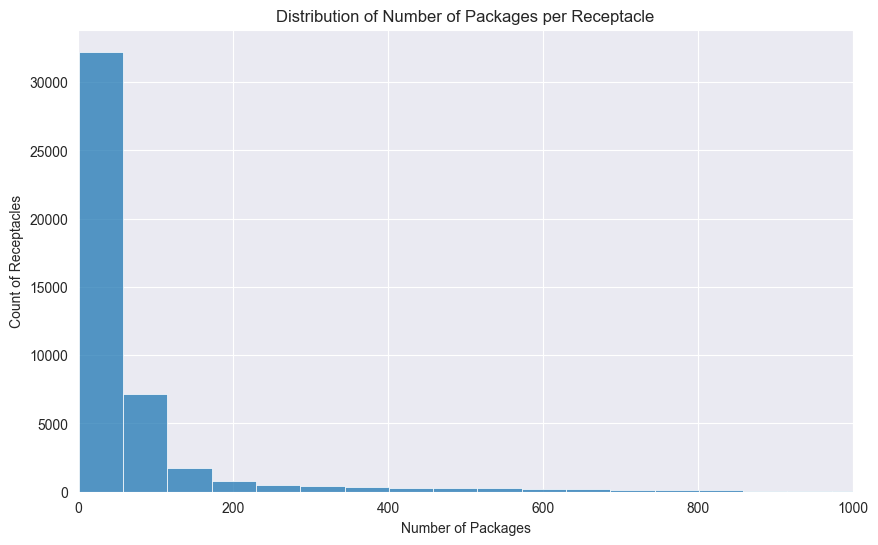

In [135]:
#visualize the distribution of num_packages per receptacle
plt.figure(figsize=(10,6))
sns.histplot(packages_per_receptacle['num_packages'], bins=100, kde=False)
plt.title('Distribution of Number of Packages per Receptacle')
plt.xlabel('Number of Packages')
plt.ylabel('Count of Receptacles')
plt.xlim(0, 1000)  # Focus on receptacles with 0-50 packages
plt.show()

we notice that most receptacles have a small number of packages

In [136]:
#see receptacles with  1 package
one_package_receptacles = packages_per_receptacle[packages_per_receptacle['num_packages'] == 1]
one_package_receptacles.shape

(1208, 2)

In [123]:
#find duplicate rows in merged_df
duplicate_rows = merged_df[merged_df.duplicated()]
duplicate_rows.shape

(227564, 29)

In [140]:
# Correlation between receptacle package count and processing time
receptacle_stats = merged_df.groupby('RECPTCL_FID').agg({
    'MAILITM_FID': 'count',
    'processing_duration_days': 'max',
}).rename(columns={'MAILITM_FID': 'package_count'})

correlation = receptacle_stats['package_count'].corr(receptacle_stats['processing_duration_days'])
print(f"Correlation between package count per receptacle and processing duration: {correlation}")

Correlation between package count per receptacle and processing duration: 0.2857233272287899


we can see that there is  correlation between the number of packages in the receptacle and the processing duration

In [141]:
#see number of null values in each column of merged_df
merged_df.isnull().sum()

RECPTCL_FID                                   0
MAILITM_FID                                   0
date_package                                  0
etablissement_postal_package             127188
EVENT_TYPE_CD_package                         0
next_etablissement_postal_package       2350717
hour                                          0
day_of_week                                   0
service_indicator                             0
serial_number                                 0
country_code                                  0
origin_country_package                        0
destination_country_package                   0
origin_destination_package                    0
flow_type_package                             0
processing_duration_package                   0
processing_duration_days                      0
num_etablissements_package                    0
date_receptacle                          155649
etablissement_postal_receptacle          156253
EVENT_TYPE_CD_receptacle                